In [34]:
import numpy as np
import pandas as pd
import os

os.chdir(r'C:\Users\user\Desktop\add')

In [39]:


class CUSUMDetector:
    def __init__(self, phase1_len=50, threshold=5.0, drift=0.5):
        """
        phase1_len: Phase I(기준) 구간 길이 (샘플 수)
        threshold: decision.interval (σ 단위)
        drift: se.shift (σ 단위)
        """
        self.phase1_len = phase1_len
        self.threshold = threshold
        self.drift = drift
        self.reset()

    def reset(self):
        """내부 상태 초기화"""
        self.mean_ = None
        self.sigma_ = None
        self.k = None
        self.h = None
        self.S_pos = 0.0
        self.S_neg = 0.0

    def fit(self, X: np.ndarray):
        """
        Phase I 데이터로부터 μ₀, σ₀, k, h 계산
        X: 1D array-like (phase1_len 길이)
        """
        x1 = np.asarray(X, dtype=float)
        if x1.ndim != 1 or len(x1) < self.phase1_len:
            raise ValueError("fit()에는 길이 phase1_len 이상의 1D 배열을 넣어야 합니다.")
        # 기준 구간
        p1 = x1[:self.phase1_len]
        self.mean_  = p1.mean() # axis = 0 추가해서 평균벡터로 만들기
        self.sigma_ = p1.std(ddof=1) # axis = 0 추가해서 공분산 행렬로 만들기
        # qcc::cusum 매핑
        # k = se.shift * σ₀ / 2
        self.k = (self.drift * self.sigma_) / 2.0
        # h = decision.interval * σ₀
        self.h = self.threshold * self.sigma_
        # 누적합 초기화
        self.S_pos = 0.0
        self.S_neg = 0.0

    def update(self, x: np.ndarray) -> bool:
        """
        Phase II 한 점씩 호출
        x: 단일 관측값 (스칼라)
        Returns:
          True  → S_pos > h 이거나 –S_neg > h 이면 (상향/하향 탐지)
          False → 아직 탐지 아님
        """
        if self.mean_ is None:
            raise RuntimeError("먼저 fit()을 호출하여 Phase I를 설정하세요.")
        xi = float(x)
        s = xi - self.mean_ - self.k
        self.S_pos = max(0.0, self.S_pos + s)
        self.S_neg = min(0.0, self.S_neg + s)
        # 상향 또는 하향 임계 초과 여부
        return (self.S_pos > self.h) or ((-self.S_neg) > self.h)


In [40]:
def load_data_long(file_path: str):
    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()
    pivot = df.pivot_table(
        index=["time", "Label"],
        columns="Variable",
        values="Value",
        aggfunc="first"
    ).sort_index()
    X_raw = pivot.to_numpy(dtype=float)
    y_raw = np.array([lab for (_, lab) in pivot.index], dtype=int)
    return X_raw, y_raw, {c: c for c in np.unique(y_raw)}

In [41]:
def create_training_windows(X: np.ndarray, y: np.ndarray, window_size: int, step: int = 1):
    if X.ndim == 2 and X.shape[0] < X.shape[1]:
        X = X.T
    T, F = X.shape
    windows, labels = [], []
    for start in range(0, T - window_size + 1, step):
        end = start + window_size
        win = X[start:end]
        windows.append(win)
        labels.append(y[end - 1])
    X_windows = np.stack(windows)
    y_windows = np.array(labels)
    return X_windows, y_windows

In [42]:
df = pd.read_csv('Et_H_CO.csv')
df.columns = df.columns.str.strip()
pivot = df.pivot_table(
    index=["time", "Label"],
    columns="Variable",
    values="Value",
    aggfunc="first"
).sort_index()
pivot.to_numpy(dtype = float)

array([[629., 719., 331., ..., 572., 566., 700.],
       [644., 737., 334., ..., 548., 584., 727.],
       [665., 759., 342., ..., 598., 593., 739.],
       ...,
       [721., 815., 359., ..., 705., 675., 853.],
       [730., 829., 359., ..., 656., 686., 865.],
       [742., 843., 363., ..., 707., 694., 872.]])

In [43]:
X_raw, y_raw, label_mapping = load_data_long("Et_H_CO.csv")

In [44]:
window_size = 5
X_train, y_train = create_training_windows(X_raw, y_raw, window_size)

In [8]:
X_raw[:10,]

array([[629., 719., 331., 273., 518., 572., 566., 700.],
       [644., 737., 334., 272., 521., 548., 584., 727.],
       [665., 759., 342., 275., 531., 598., 593., 739.],
       [660., 754., 341., 279., 533., 627., 592., 735.],
       [630., 719., 331., 274., 518., 571., 566., 700.],
       [643., 736., 333., 272., 521., 548., 583., 727.],
       [665., 759., 342., 275., 531., 598., 593., 739.],
       [662., 754., 341., 279., 533., 626., 592., 735.],
       [630., 719., 333., 273., 518., 571., 566., 701.],
       [643., 736., 334., 272., 519., 547., 584., 728.]])

In [10]:
cusum = CUSUMDetector(phase1_len=20, threshold=5.0, drift=0.0)
cusum

In [11]:
cusum.fit(X_raw[:20].mean(axis=1))

In [12]:
print(cusum.mean_)
print(cusum.sigma_)
print(cusum.k)
print(cusum.h)


552.99375
11.536802881374207
0.0
57.684014406871036


In [13]:
x1 = np.asarray(X_raw[:20], dtype=float)
x1.ndim

2

In [14]:
X_raw.shape


(11880, 8)

In [53]:
p1 = x1[:20]
print(p1.mean()) # axis = 0이 되어야 각 센서에 대한 평균이 나올텐데
print(p1.std(ddof=1)) # axis = 0이 되어야 각 센서에 대한 표준편차가 나올텐데 ?

552.99375
[14.55877381 16.2683904   4.7047009   2.76443579  6.73150488 30.08514234
 11.08092244 15.41453518]


In [54]:
def create_expanding_windows(X: np.ndarray, y: np.ndarray, min_size: int = 1):
    if X.ndim == 2 and X.shape[0] < X.shape[1]:
        X = X.T
    T, F = X.shape
    windows_list = []
    labels = []
    for end in range(min_size, T + 1):
        win = X[:end]
        windows_list.append(win)
        labels.append(y[end - 1])
    y_windows = np.array(labels)
    return windows_list, y_windows

In [55]:
X_exp, _ = create_expanding_windows(X_raw, y_raw, min_size=1)

In [65]:
X_raw[:10,]

array([[629., 719., 331., 273., 518., 572., 566., 700.],
       [644., 737., 334., 272., 521., 548., 584., 727.],
       [665., 759., 342., 275., 531., 598., 593., 739.],
       [660., 754., 341., 279., 533., 627., 592., 735.],
       [630., 719., 331., 274., 518., 571., 566., 700.],
       [643., 736., 333., 272., 521., 548., 583., 727.],
       [665., 759., 342., 275., 531., 598., 593., 739.],
       [662., 754., 341., 279., 533., 626., 592., 735.],
       [630., 719., 333., 273., 518., 571., 566., 701.],
       [643., 736., 334., 272., 519., 547., 584., 728.]])

In [62]:
X_exp

[array([[629., 719., 331., 273., 518., 572., 566., 700.]]),
 array([[629., 719., 331., 273., 518., 572., 566., 700.],
        [644., 737., 334., 272., 521., 548., 584., 727.]]),
 array([[629., 719., 331., 273., 518., 572., 566., 700.],
        [644., 737., 334., 272., 521., 548., 584., 727.],
        [665., 759., 342., 275., 531., 598., 593., 739.]]),
 array([[629., 719., 331., 273., 518., 572., 566., 700.],
        [644., 737., 334., 272., 521., 548., 584., 727.],
        [665., 759., 342., 275., 531., 598., 593., 739.],
        [660., 754., 341., 279., 533., 627., 592., 735.]]),
 array([[629., 719., 331., 273., 518., 572., 566., 700.],
        [644., 737., 334., 272., 521., 548., 584., 727.],
        [665., 759., 342., 275., 531., 598., 593., 739.],
        [660., 754., 341., 279., 533., 627., 592., 735.],
        [630., 719., 331., 274., 518., 571., 566., 700.]]),
 array([[629., 719., 331., 273., 518., 572., 566., 700.],
        [644., 737., 334., 272., 521., 548., 584., 727.],
    

In [15]:
from pyspc import *

In [17]:
X_raw

array([[629., 719., 331., ..., 572., 566., 700.],
       [644., 737., 334., ..., 548., 584., 727.],
       [665., 759., 342., ..., 598., 593., 739.],
       ...,
       [721., 815., 359., ..., 705., 675., 853.],
       [730., 829., 359., ..., 656., 686., 865.],
       [742., 843., 363., ..., 707., 694., 872.]])

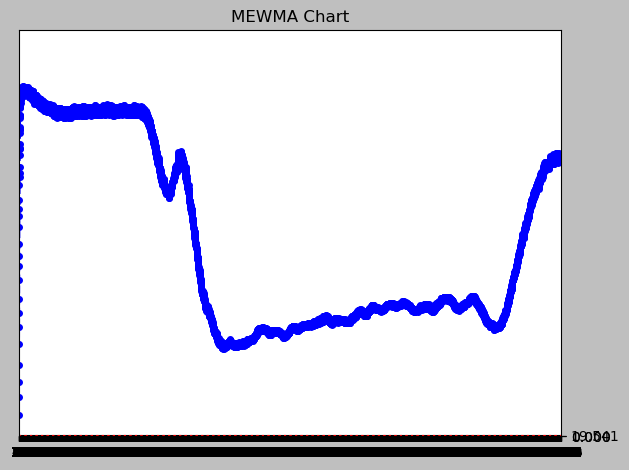

<pyspc: (-9223371925567058712)>

In [64]:
spc(X_raw) + mewma()

In [29]:
import matplotlib.pyplot as plt

# 예시 데이터
data = [10.1, 10.2, 10.3, 10.4, 10.5, 10.6]

# CUSUM 관리도 생성
cusum_chart = cusum(target=10.0, std=0.5, interval=4)

# 결과 출력
cusum_chart.plot(data, size = 1)

([[0,
   0,
   0.05000000000000071,
   0.20000000000000107,
   0.45000000000000107,
   0.8000000000000007],
  [0, 0, 0, 0, 0, 0]],
 0,
 -2.0,
 2.0,
 'CUSUM Chart')

In [58]:
X_raw.shape
y_raw.shape

(11880,)

In [63]:
# CUSUM 관리도 생성
cusum_chart = cusum(target=y_raw, std=0.5, interval=4)

# 결과 출력
size = int(len(X_raw) * 0.01) 
cusum_chart.plot(X_raw[:,0], size =100)

AxisError: axis 1 is out of bounds for array of dimension 1

In [32]:
# 데이터 불러오기 : gas
gas_data = pd.read_csv('GAS_v2.csv', index_col = 0)
gas_data

,BD.1,BD.1.1,BD.1.2,BD.1.3,BD.1.4,BD.1.5,BD.1.6,BD.1.7,BD.1.8,BD.1.9,...,BD.5.6,BD.5.7,BD.5.8,BD.5.9,BD.5.10,BD.5.11,BD.5.12,BD.5.13,BD.5.14,BD.5.15
09:32:55,24213.621743,23985.363235,23966.930909,24447.283750,24448.903405,24058.452911,24595.657880,24213.517250,24139.979260,24412.382845,...,24684.825606,24521.412438,24235.675634,24469.434551,24304.519401,24230.193302,24020.539125,24567.698953,24646.249740,24353.634612
09:32:56,24207.289579,23984.207261,23977.850103,24451.743601,24448.671732,24066.843195,24582.917627,24217.668143,24131.142621,24414.093901,...,24695.830251,24528.860739,24236.969881,24477.351282,24302.725532,24234.145468,24019.312291,24575.112507,24643.120631,24353.295564
09:32:57,24216.357366,23983.975591,23970.786857,24441.452583,24460.554763,24058.467287,24583.187163,24216.109287,24140.231549,24417.359744,...,24681.695603,24526.300473,24245.076938,24474.351992,24305.893913,24236.010790,24031.546210,24571.464138,24649.404807,24350.484463
09:32:58,24204.548158,23979.118904,23968.896308,24444.173465,24447.954931,24056.935314,24581.050184,24214.782910,24152.488167,24403.199010,...,24676.731434,24523.038019,24230.596355,24479.672953,24305.390337,24230.170746,24030.053507,24566.730661,24648.716754,24355.054264
09:32:59,24221.490916,23984.720250,23963.701473,24457.858426,24447.227678,24062.733710,24599.656138,24218.120705,24140.330296,24420.729312,...,24681.837815,24523.507154,24246.175014,24479.415291,24300.433991,24229.083541,24021.620093,24575.676585,24638.504103,24357.985022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
09:36:46,21982.000000,21857.000000,21856.000000,21393.000000,21375.000000,21272.000000,21506.000000,21434.000000,21523.000000,21472.000000,...,20545.000000,20662.000000,21118.000000,20582.000000,20785.000000,20935.000000,21353.000000,20717.000000,21248.000000,21390.000000
09:36:47,21894.000000,21811.000000,21779.000000,21331.000000,21340.000000,21203.000000,21462.000000,21387.000000,21446.000000,21400.000000,...,20478.000000,20601.000000,21047.000000,20332.000000,20708.000000,20911.000000,21276.000000,20639.000000,21121.000000,21335.000000
09:36:48,21598.000000,21652.000000,21700.000000,21240.000000,21282.000000,21125.000000,21399.000000,21337.000000,21374.000000,21320.000000,...,20490.000000,20589.000000,21012.000000,20335.000000,20668.000000,20913.000000,21224.000000,20605.000000,21111.000000,21296.000000
09:36:49,21529.000000,21562.000000,21536.000000,21190.000000,21206.000000,20893.000000,21321.000000,21277.000000,21301.000000,21241.000000,...,20504.000000,20617.000000,21001.000000,20382.000000,20664.000000,20930.000000,21194.000000,20601.000000,21115.000000,21272.000000


In [35]:
#noise 추가 : 241015
gas_data1 = gas_data + np.random.normal(0, 30, size = (236, 80))
gas_data1

,BD.1,BD.1.1,BD.1.2,BD.1.3,BD.1.4,BD.1.5,BD.1.6,BD.1.7,BD.1.8,BD.1.9,...,BD.5.6,BD.5.7,BD.5.8,BD.5.9,BD.5.10,BD.5.11,BD.5.12,BD.5.13,BD.5.14,BD.5.15
09:32:55,24203.712849,23959.318851,23921.760357,24424.993761,24492.814628,24054.755028,24580.133815,24210.272129,24160.635696,24422.561530,...,24703.173700,24517.640274,24161.325415,24470.478772,24298.783659,24216.092445,24047.793622,24574.972065,24655.442512,24345.150288
09:32:56,24221.504397,23989.721531,24002.488031,24548.436470,24412.945803,24046.434369,24610.441359,24193.042885,24163.225535,24427.304406,...,24765.450593,24522.852291,24203.118328,24522.703891,24316.292064,24219.951973,24066.339397,24570.066253,24629.601780,24319.183851
09:32:57,24205.210883,23959.242146,23946.941094,24413.077990,24461.298122,24065.993705,24538.366926,24150.781578,24188.525939,24389.758192,...,24675.871264,24525.197580,24236.571949,24421.416825,24344.995286,24214.964583,24032.155417,24546.323546,24647.927483,24331.798051
09:32:58,24165.844043,24021.280385,23947.099315,24469.553117,24427.292997,24076.696385,24586.206035,24223.791858,24197.859848,24424.449303,...,24667.420640,24527.965830,24185.207892,24499.939996,24335.005110,24214.251125,24006.579220,24577.159767,24647.346150,24373.084849
09:32:59,24190.797217,24022.975214,23902.258461,24459.601526,24408.622788,24068.172914,24558.310703,24245.620875,24108.863004,24465.537573,...,24695.847796,24594.950338,24261.812151,24462.936497,24345.898385,24212.566216,24032.187047,24547.181027,24673.071035,24346.824228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
09:36:46,21959.880540,21890.809793,21864.606555,21371.300924,21366.682646,21217.882532,21477.780125,21469.420173,21532.655760,21470.437667,...,20568.614892,20631.901109,21111.374773,20534.399706,20763.668271,20965.024053,21347.564399,20717.696526,21252.568445,21424.273376
09:36:47,21868.634233,21841.226868,21774.001878,21260.140658,21302.261634,21155.213173,21476.298675,21351.200798,21453.087140,21451.323631,...,20460.062734,20594.551211,21053.345369,20331.778460,20757.769218,20917.449795,21282.586632,20584.355943,21149.437409,21362.977915
09:36:48,21650.265018,21664.695053,21675.069919,21220.828568,21273.336393,21157.606748,21404.072540,21342.027370,21370.634042,21300.179774,...,20533.601170,20613.115347,20986.119019,20339.577148,20611.150469,20840.413730,21205.298065,20584.604774,21161.431718,21308.362445
09:36:49,21500.457748,21572.770342,21541.481028,21161.663026,21173.768436,20901.654755,21323.139225,21290.497631,21303.158679,21204.074956,...,20489.944839,20566.480281,20992.036316,20407.959219,20638.747011,20945.909049,21155.187763,20624.591734,21128.155294,21258.672032


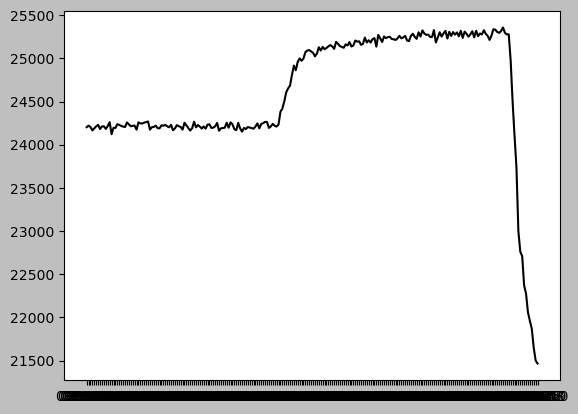

In [36]:
plt.plot(gas_data1.iloc[:, 0])
plt.show()

In [37]:
random_col = np.random.randint(0, gas_data1.shape[1], size = 4)

gas_random = gas_data1.iloc[:, random_col]
gas_random

,BD.2.9,BD.1.9,BD.5.1,BD.2.3
09:32:55,24569.269154,24422.561530,24559.914045,24461.537255
09:32:56,24583.825159,24427.304406,24564.198457,24492.848672
09:32:57,24650.148186,24389.758192,24555.033136,24453.343612
09:32:58,24598.435745,24424.449303,24530.957619,24486.679151
09:32:59,24685.791367,24465.537573,24595.688875,24442.195590
...,...,...,...,...
09:36:46,21092.034637,21470.437667,20654.835196,20851.000222
09:36:47,21086.600006,21451.323631,20573.054561,20808.876955
09:36:48,21056.761945,21300.179774,20523.284773,20797.287383
09:36:49,21082.664888,21204.074956,20495.476928,20788.339909


In [38]:
time_labels = gas_data1.index
time_labels

Index(['09:32:55', '09:32:56', '09:32:57', '09:32:58', '09:32:59', '09:33:00',
       '09:33:01', '09:33:02', '09:33:03', '09:33:04',
       ...
       '09:36:41', '09:36:42', '09:36:43', '09:36:44', '09:36:45', '09:36:46',
       '09:36:47', '09:36:48', '09:36:49', '09:36:50'],
      dtype='object', length=236)

In [45]:
y_raw

array([1, 2, 3, ..., 2, 3, 4])